In [95]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
from torchvision import transforms
from torchvision import transforms

In [96]:
#数据准备阶段

#对数据做归一化（-1，1）
transform = transforms.Compose([
    transforms.ToTensor(),  #0-1归一化，同时进行格式转换
    transforms.Normalize(0.5, 0.5)
])

train_ds = torchvision.datasets.MNIST('data', train=True, transform=transform, download=True)
#MNIST数据集中数据的大小是28*28

dataloader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)

imgs, _ = next(iter(dataloader))
imgs.shape

torch.Size([64, 1, 28, 28])

In [97]:
#定义生成器
#输入是长度为100的噪声（正态分布随机数）
#输出是28*28的图片
# 网络结构：
#Linear1:100->256
#Linear2:256->512
#Linear3:512->28*28
#reshape:28*28->1*28*28

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=100, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=28 * 28),
            #对于生成器模型，一般最后一层的激活函数使用的是Tanh()
            nn.Tanh()  #取值范围（-1，1）
        )

    def forward(self, x):  #x表示长度为100的noise的输入
        img = self.main(x)
        img = img.view(-1, 28, 28,
                       1)  #在 view() 函数中，-1 是一个特殊的值，表示“自动推断”。当你指定一个维度为 -1 时，PyTorch 会自动计算该维度的大小，使得重塑后的张量总元素数量与原始张量保持一致。
        return img

In [98]:
#判别器
# 输入：（1，28，28）的图片
#输出：二分类的概率值（使用sigmoid（）函数激活（0-1））
#BECLoss进行计算交叉熵损失
#ReLU():x>0:输出x；x<0，输出0
#LeakyReLU():f(x):x>0，输出x；x<0，输出a*x（a表示一个很小的斜率值）
#在判别器中一般推荐使用LeakyReLU()

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=512),
            nn.LeakyReLU(),  #会保留一定的梯度
            nn.Linear(in_features=512, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1),
            #对于生成器模型，一般最后一层的激活函数使用的是Tanh()
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)  #将一张图片（1*28*28），展平成一个张量（28*28），作为输入
        x = self.main(x)
        return x

In [99]:
#初始化模型，优化器以及损失计算函数

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

#优化器
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)

#损失函数
loss_fn = nn.BCELoss()


In [100]:
from matplotlib import pyplot as plt


#绘图

def gen_image_plot(model, test_input):
    prediction = np.squeeze(
        model(
            test_input).detach().cpu().numpy())  #使用模型对输入数据进行预测，并将预测结果从计算图中分离并移动到 CPU 上。使用squeeze()函数将（1*28*28）中的1(通道数)消除。注意：prediction是一个批次的结果
    fig = plt.figure(figsize=(4, 4))  #创建一个宽为 4 英寸、高为 4 英寸的图像。
    for i in range(prediction.shape[0]):  #prediction.shape[0] 是批量中图像的数量
        plt.subplot(4, 4, i + 1)  #4, 4 表示将图形窗口划分为 4 行 4 列，总共 16 个子图,i + 1 表示子图的索引（从 1 开始
        plt.imshow((prediction[
                        i] + 1) / 2, )  #因为生成器的输出是（-1，1）之间的，将其恢复到（0，1）之间绘图。imshow（）函数的取值要求：（0，1）之间float值，或（0，255）之间的uint值
        plt.axis('off')
    plt.show()

In [101]:
test_input = torch.rand(16, 100, device=device)  #16个长度为100的正态分布随机数

epoch: 0  d_epoch_loss: tensor(0.3883, device='cuda:0')  g_epoch_loss: tensor(2.6601, device='cuda:0')


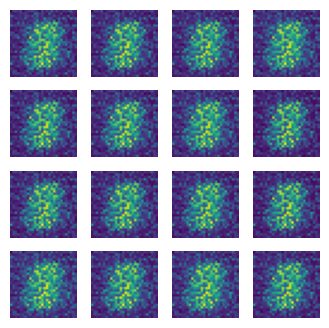

epoch: 1  d_epoch_loss: tensor(0.2483, device='cuda:0')  g_epoch_loss: tensor(3.0379, device='cuda:0')


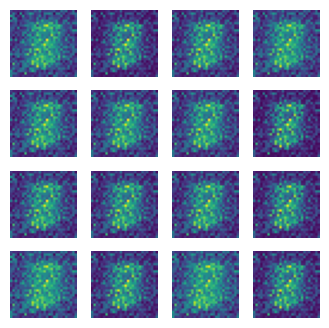

epoch: 2  d_epoch_loss: tensor(0.2415, device='cuda:0')  g_epoch_loss: tensor(3.1542, device='cuda:0')


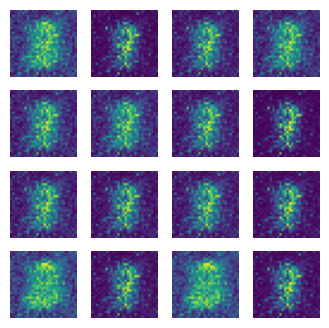

epoch: 3  d_epoch_loss: tensor(0.1522, device='cuda:0')  g_epoch_loss: tensor(3.7169, device='cuda:0')


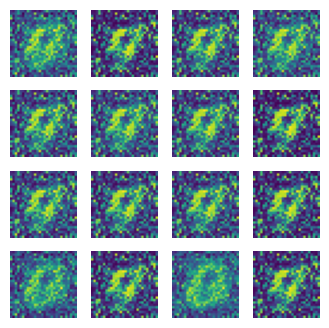

epoch: 4  d_epoch_loss: tensor(0.1022, device='cuda:0')  g_epoch_loss: tensor(4.9392, device='cuda:0')


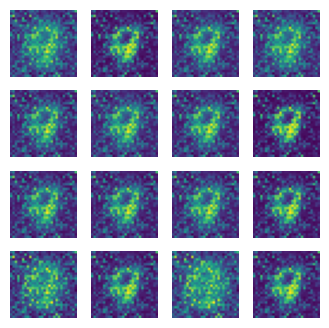

epoch: 5  d_epoch_loss: tensor(0.1037, device='cuda:0')  g_epoch_loss: tensor(4.9573, device='cuda:0')


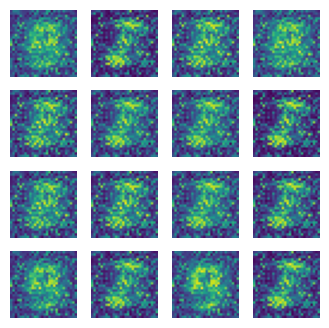

epoch: 6  d_epoch_loss: tensor(0.1026, device='cuda:0')  g_epoch_loss: tensor(5.2991, device='cuda:0')


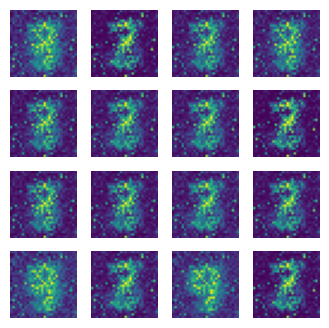

epoch: 7  d_epoch_loss: tensor(0.1019, device='cuda:0')  g_epoch_loss: tensor(6.0032, device='cuda:0')


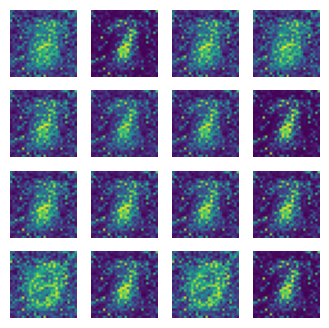

epoch: 8  d_epoch_loss: tensor(0.1229, device='cuda:0')  g_epoch_loss: tensor(5.3705, device='cuda:0')


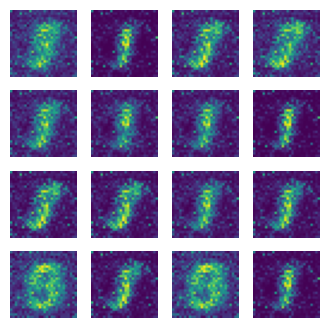

epoch: 9  d_epoch_loss: tensor(0.1404, device='cuda:0')  g_epoch_loss: tensor(5.1060, device='cuda:0')


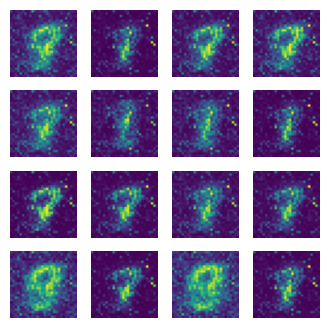

epoch: 10  d_epoch_loss: tensor(0.1572, device='cuda:0')  g_epoch_loss: tensor(5.3471, device='cuda:0')


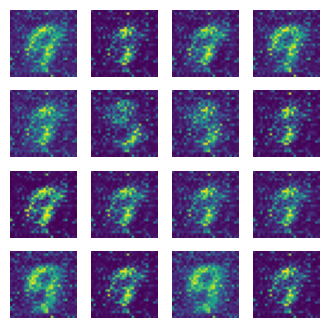

epoch: 11  d_epoch_loss: tensor(0.1410, device='cuda:0')  g_epoch_loss: tensor(6.0883, device='cuda:0')


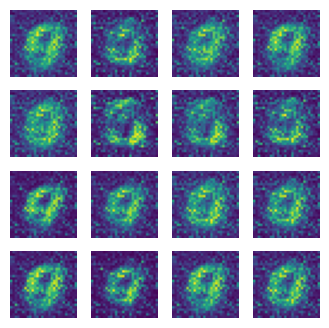

epoch: 12  d_epoch_loss: tensor(0.1321, device='cuda:0')  g_epoch_loss: tensor(5.7959, device='cuda:0')


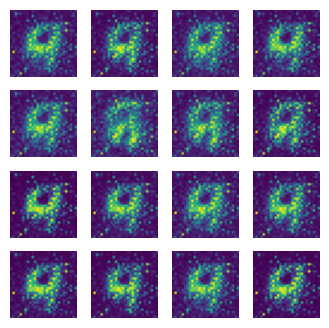

epoch: 13  d_epoch_loss: tensor(0.1320, device='cuda:0')  g_epoch_loss: tensor(5.8812, device='cuda:0')


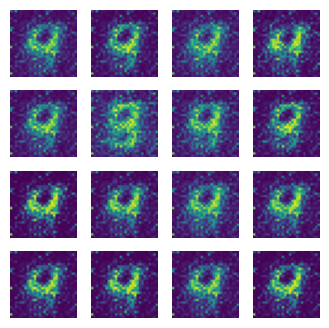

epoch: 14  d_epoch_loss: tensor(0.1504, device='cuda:0')  g_epoch_loss: tensor(5.8464, device='cuda:0')


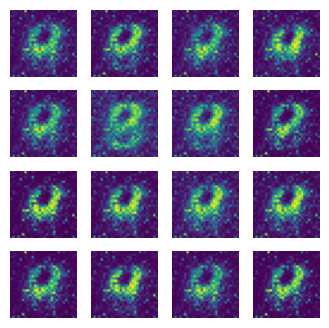

epoch: 15  d_epoch_loss: tensor(0.1621, device='cuda:0')  g_epoch_loss: tensor(5.9216, device='cuda:0')


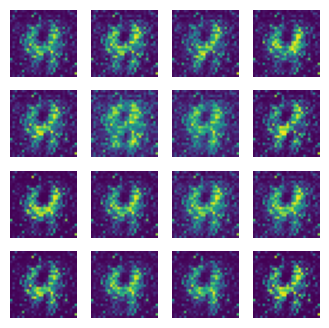

epoch: 16  d_epoch_loss: tensor(0.1634, device='cuda:0')  g_epoch_loss: tensor(5.6977, device='cuda:0')


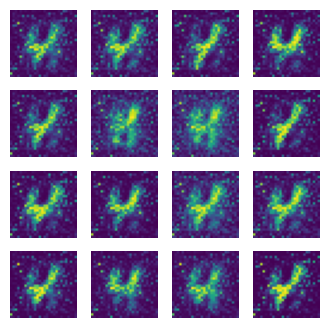

epoch: 17  d_epoch_loss: tensor(0.2140, device='cuda:0')  g_epoch_loss: tensor(5.1676, device='cuda:0')


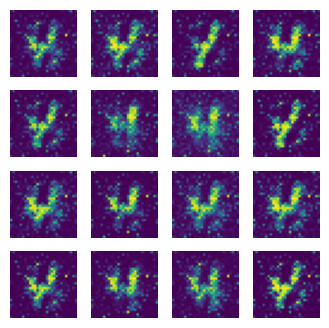

epoch: 18  d_epoch_loss: tensor(0.2224, device='cuda:0')  g_epoch_loss: tensor(5.0752, device='cuda:0')


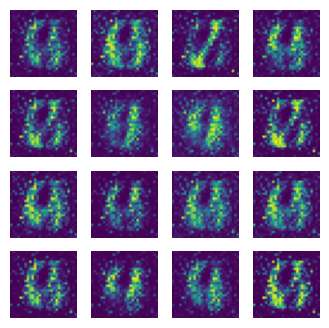

epoch: 19  d_epoch_loss: tensor(0.2098, device='cuda:0')  g_epoch_loss: tensor(5.0051, device='cuda:0')


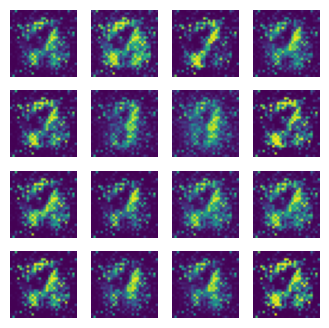

epoch: 20  d_epoch_loss: tensor(0.2201, device='cuda:0')  g_epoch_loss: tensor(4.8448, device='cuda:0')


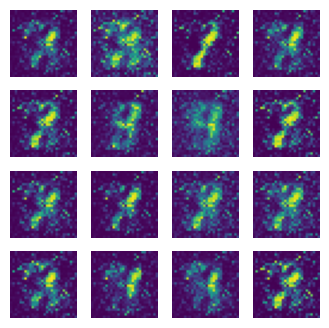

epoch: 21  d_epoch_loss: tensor(0.2559, device='cuda:0')  g_epoch_loss: tensor(4.5380, device='cuda:0')


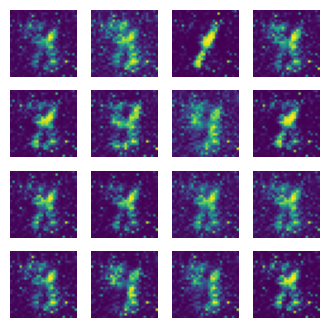

epoch: 22  d_epoch_loss: tensor(0.2579, device='cuda:0')  g_epoch_loss: tensor(4.4749, device='cuda:0')


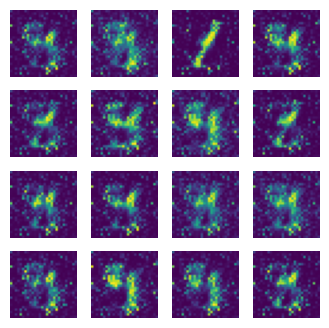

epoch: 23  d_epoch_loss: tensor(0.2864, device='cuda:0')  g_epoch_loss: tensor(4.2937, device='cuda:0')


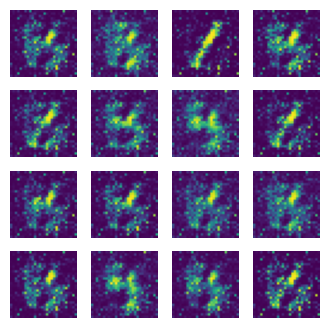

epoch: 24  d_epoch_loss: tensor(0.3003, device='cuda:0')  g_epoch_loss: tensor(3.8425, device='cuda:0')


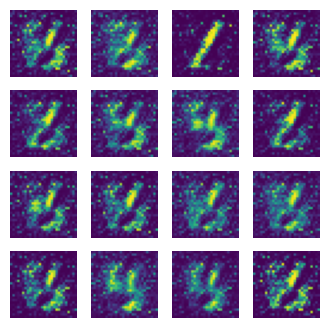

epoch: 25  d_epoch_loss: tensor(0.3422, device='cuda:0')  g_epoch_loss: tensor(3.4943, device='cuda:0')


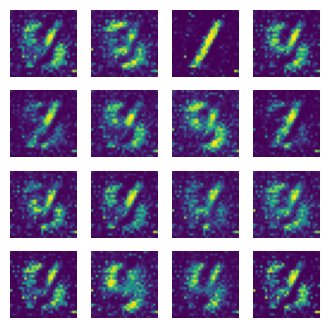

epoch: 26  d_epoch_loss: tensor(0.3703, device='cuda:0')  g_epoch_loss: tensor(3.3043, device='cuda:0')


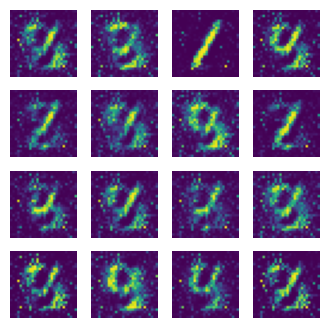

epoch: 27  d_epoch_loss: tensor(0.3545, device='cuda:0')  g_epoch_loss: tensor(3.3830, device='cuda:0')


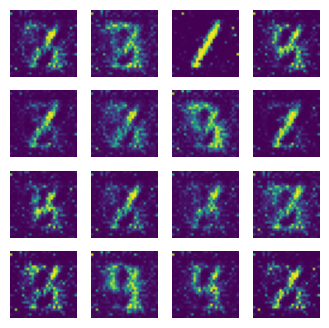

epoch: 28  d_epoch_loss: tensor(0.3399, device='cuda:0')  g_epoch_loss: tensor(3.6688, device='cuda:0')


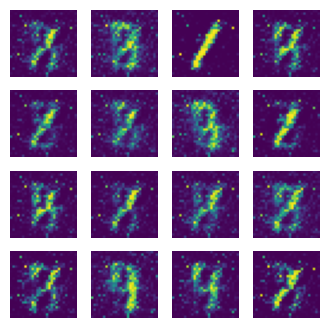

epoch: 29  d_epoch_loss: tensor(0.3316, device='cuda:0')  g_epoch_loss: tensor(3.7005, device='cuda:0')


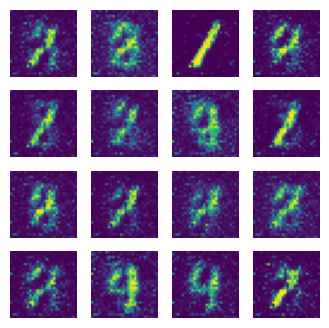

epoch: 30  d_epoch_loss: tensor(0.3680, device='cuda:0')  g_epoch_loss: tensor(3.2841, device='cuda:0')


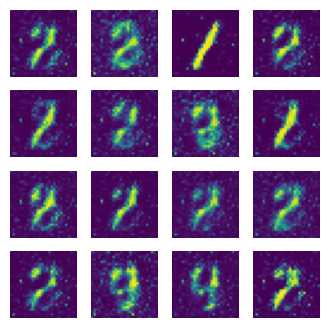

epoch: 31  d_epoch_loss: tensor(0.3946, device='cuda:0')  g_epoch_loss: tensor(2.9743, device='cuda:0')


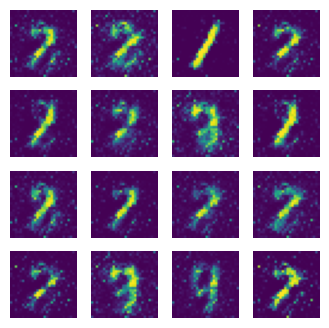

epoch: 32  d_epoch_loss: tensor(0.4285, device='cuda:0')  g_epoch_loss: tensor(2.8297, device='cuda:0')


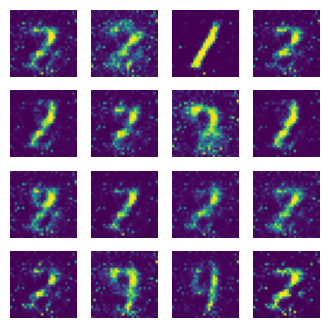

epoch: 33  d_epoch_loss: tensor(0.4252, device='cuda:0')  g_epoch_loss: tensor(2.8724, device='cuda:0')


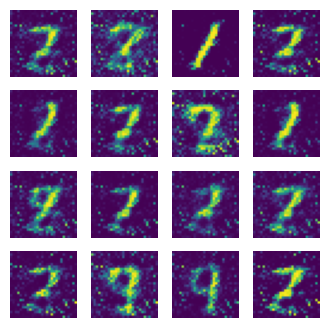

epoch: 34  d_epoch_loss: tensor(0.4455, device='cuda:0')  g_epoch_loss: tensor(2.7957, device='cuda:0')


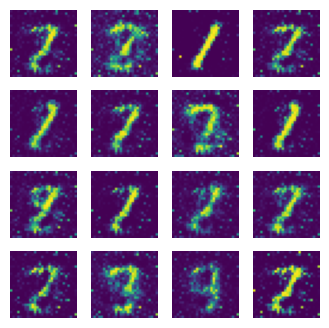

epoch: 35  d_epoch_loss: tensor(0.4451, device='cuda:0')  g_epoch_loss: tensor(2.8270, device='cuda:0')


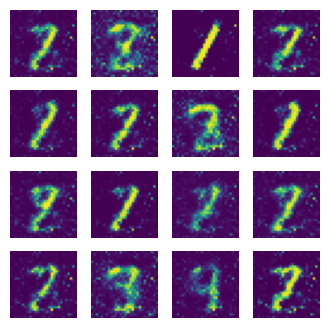

epoch: 36  d_epoch_loss: tensor(0.4434, device='cuda:0')  g_epoch_loss: tensor(2.8705, device='cuda:0')


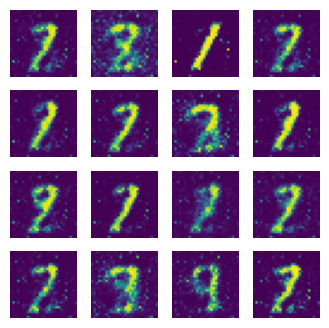

epoch: 37  d_epoch_loss: tensor(0.4724, device='cuda:0')  g_epoch_loss: tensor(2.6617, device='cuda:0')


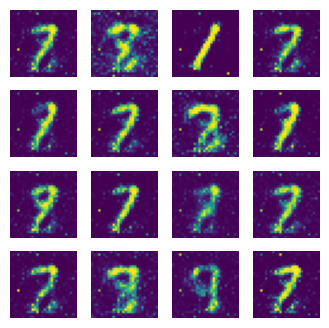

epoch: 38  d_epoch_loss: tensor(0.4936, device='cuda:0')  g_epoch_loss: tensor(2.5473, device='cuda:0')


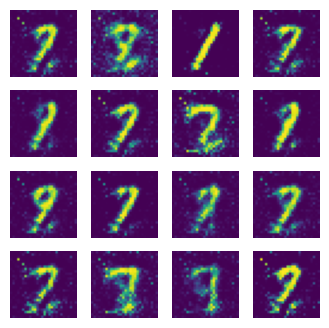

epoch: 39  d_epoch_loss: tensor(0.4904, device='cuda:0')  g_epoch_loss: tensor(2.5756, device='cuda:0')


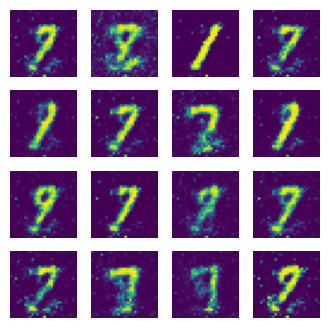

epoch: 40  d_epoch_loss: tensor(0.4891, device='cuda:0')  g_epoch_loss: tensor(2.5971, device='cuda:0')


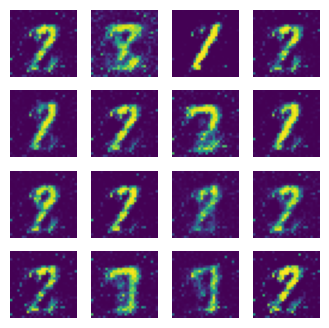

epoch: 41  d_epoch_loss: tensor(0.4829, device='cuda:0')  g_epoch_loss: tensor(2.7106, device='cuda:0')


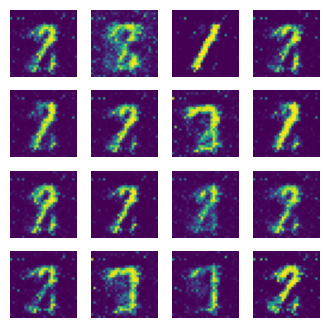

epoch: 42  d_epoch_loss: tensor(0.4875, device='cuda:0')  g_epoch_loss: tensor(2.6646, device='cuda:0')


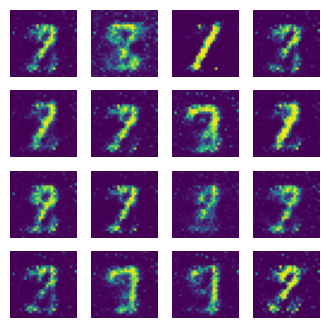

epoch: 43  d_epoch_loss: tensor(0.4970, device='cuda:0')  g_epoch_loss: tensor(2.5429, device='cuda:0')


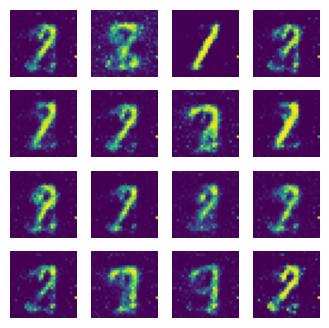

epoch: 44  d_epoch_loss: tensor(0.5194, device='cuda:0')  g_epoch_loss: tensor(2.4371, device='cuda:0')


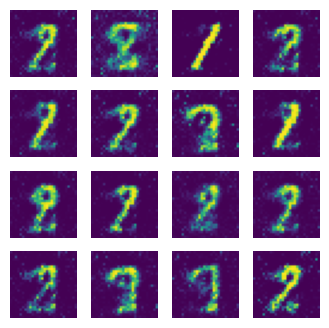

epoch: 45  d_epoch_loss: tensor(0.5371, device='cuda:0')  g_epoch_loss: tensor(2.3303, device='cuda:0')


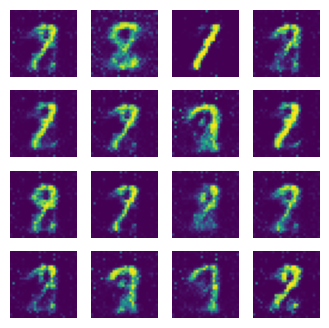

epoch: 46  d_epoch_loss: tensor(0.5345, device='cuda:0')  g_epoch_loss: tensor(2.3788, device='cuda:0')


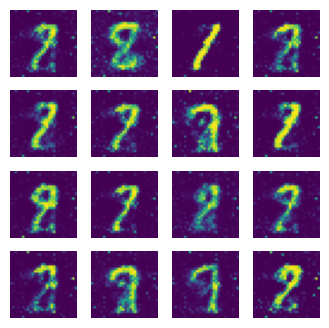

epoch: 47  d_epoch_loss: tensor(0.5256, device='cuda:0')  g_epoch_loss: tensor(2.4087, device='cuda:0')


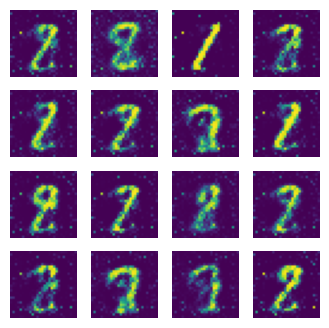

epoch: 48  d_epoch_loss: tensor(0.5042, device='cuda:0')  g_epoch_loss: tensor(2.5556, device='cuda:0')


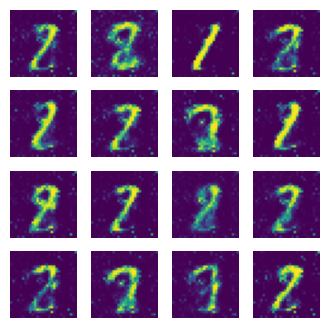

epoch: 49  d_epoch_loss: tensor(0.5227, device='cuda:0')  g_epoch_loss: tensor(2.4505, device='cuda:0')


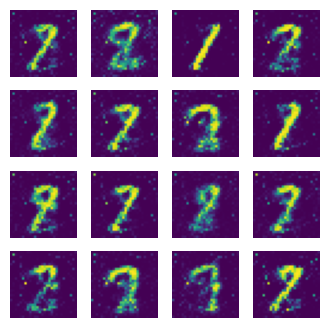

In [102]:
#Gan网络训练

D_loss = []
G_loss = []

#训练循环
for epoch in range(50):
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader)  #len(dataloader)返回批次数；len(dataset)返回样本数
    for step, (imgs, _) in enumerate(dataloader):  #img 是一个张量（Tensor），包含了多个图像
        img = imgs.to(device)
        size = img.size(0)
        random_noise = torch.randn(size, 100, device=device)  #作为生成器的输入 
        #=================================================================================================
        #判别器(带入到判别器的视角)
        d_optimizer.zero_grad()  #将前面步骤中的梯度归零
        real_output = discriminator(img)  #对判别器输入真实图片，得到对真实图片的预测结果，判别为真的话，结果为1
        d_real_loss = loss_fn(real_output, torch.ones_like(real_output).to(device))  #我们希望判定为真，即为1。得到判别器在真实图像上的损失。
        d_real_loss.backward()  #计算梯度
        #生成器
        gen_image = generator(random_noise)
        fake_output = discriminator(
            gen_image.detach())  #交给判别器判断，判别器输入生成图片，fake_output是对生成图片的预测结果 #我们需要优化判别器，而不是生成器，所以需要在这里阶段梯度 #.detach() 方法来阻止梯度回传到生成器，从而只优化判别器。
        d_fake_loss = loss_fn(fake_output, torch.zeros_like(fake_output).to(device))  #希望fake_out判定为假，即为0。得到判别器在生成图片上的损失
        d_fake_loss.backward()  #对生成图像（假图像）的损失，并通过反向传播计算梯度

        d_loss = d_real_loss + d_fake_loss  #判别器总体损失
        d_optimizer.step()  #这是优化器的一步操作，用于根据计算出的梯度更新判别器的参数
        #=================================================================================================
        #生成器（带入到生成器的视角）
        g_optimizer.zero_grad()
        fake_output = discriminator(gen_image)  #这里不截断梯度，因为现在这里要优化生成器模型
        gen_loss = loss_fn(fake_output, torch.ones_like(fake_output).to(device))  #在这个视角下，我们希望我们的生成器的结果可以为真，即为1
        gen_loss.backward()
        g_optimizer.step()

        with torch.no_grad():
            d_epoch_loss += d_loss
            g_epoch_loss += gen_loss
    #torch.no_grad() 是一个上下文管理器（context manager），用于临时禁用梯度计算。它在推理（inference）或评估模型时非常有用，尤其是在不需要计算梯度的情况下，可以显著减少内存消耗并提高计算效率
    with torch.no_grad():
        d_epoch_loss /= count
        g_epoch_loss /= count
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)
        print('epoch:', epoch, ' d_epoch_loss:', d_epoch_loss, ' g_epoch_loss:', g_epoch_loss)
        gen_image_plot(generator, test_input)
